In [2]:
from jax import numpy as jnp



In [1]:
%load_ext autoreload
%autoreload 2
import jax
from jax import vmap
from jax.random import split, PRNGKey
from jax import numpy as jnp
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions

from gaussian_mixture import build_cov_matrices, gaussian_mixture_log_p, gaussian_mixture, gaussian_mixture_log_p_single_obs, build_cov_matrices, sample_observations
from utils import AttrDict
from train_gaussian_mixture import initialize_model
from matplotlib import pyplot as plt

In [2]:
def draw_bivariate_dist(log_prob,mins,maxs,res):
    min_x,min_y = mins
    max_x,max_y = maxs
    
    xs= (jnp.arange(res)/res *(max_x-min_x) + min_x)
    ys= (jnp.arange(res)/res *(max_y-min_y) + min_y)

    def get_dist_val_pt(x,y,log_pdf_func):
        assert x.ndim==0 and y.ndim==0
        print(jnp.stack([x,y]).shape)
        return log_pdf_func(jnp.stack([x,y]))

    all_log_pdf = vmap(
        vmap(
            get_dist_val_pt, 
            in_axes=(0,None,None),
            
        ),
        in_axes=(None,0,None)
    )(xs,ys,log_prob)
    print(jnp.unique(all_log_pdf))
    fig1, ax2 = plt.subplots(constrained_layout=True)
    print(all_log_pdf.shape)
    cs = ax2.contourf(xs, ys, all_log_pdf[:,:], 1000)
    cbar = fig1.colorbar(cs)
    return ax2, fig1

In [4]:
m_cfg = AttrDict(
        key=PRNGKey(0),
        max_num_mixtures=6,
        dims=2,
        d_model=256,
        dropout_rate=0.1,
        num_mixtures_mlp_width=100,
        num_mixtures_mlp_depth=1,
        flows_num_blocks=8,
        flows_num_layers_per_block=1,
        flows_num_augment=180,
        num_enc_layers=4
    )
m = initialize_model(
        model_cfg=m_cfg,
        load_idx=None,
        chkpt_folder="gaussian_mixture_chkpts_001/",
    )

In [5]:
# my_g = lambda x: gaussian_mixture(x)
num_mixtures, means, cov_terms, class_labels, obs = vmap(gaussian_mixture)(split(PRNGKey(2),10))
jnp.linalg.norm(means[0][:num_mixtures[0]+1], axis=-1), cov_terms[0][:num_mixtures[0]+1], class_labels[0]

(Array([0.9024438 , 0.34769976], dtype=float32),
 Array([[ 0.02077475,  0.15473475,  0.19918396],
        [-0.07427669, -0.1221776 ,  0.05170922]], dtype=float32),
 Array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 0], dtype=int32))

(Array([[-0.6554527 ,  0.3109312 ],
        [-0.19256115,  0.45137668]], dtype=float32),)

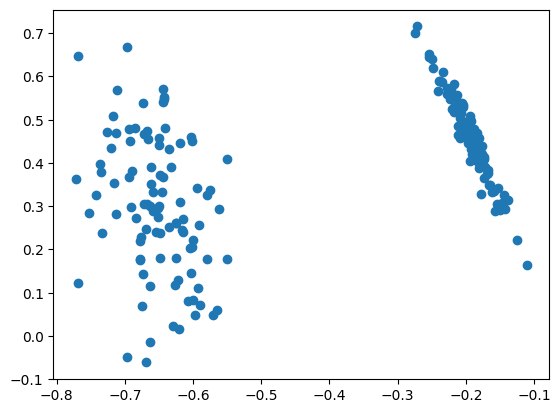

In [9]:
idx = 3
plt.scatter(obs[idx,:,0], obs[idx,:,1])
means[idx][:num_mixtures[idx]+1],

In [6]:
print(f"the log_p of the latents given the model are\
      {vmap(m.log_p)(num_mixtures,means,cov_terms,obs,split(PRNGKey(658),10))}")
# print(f"the log_p of the observations given ")
idx = 0
print(f"the log_p of the observations given the true latents are\
      {gaussian_mixture_log_p(obs[idx],means[idx],cov_terms[idx],num_mixtures[idx])}")
num_mix_hat, means_hat, cov_terms_hat = vmap(m.rsample, in_axes=(None,0))(obs[idx],split(PRNGKey(5),1000))
log_p = vmap(gaussian_mixture_log_p,in_axes=(None,0,0,0))(obs[idx],means_hat,cov_terms_hat,num_mix_hat)
print(f"the log_p of the observations given the model latents are {log_p.mean()}")


the log_p of the latents given the model are      [-278.71167 -275.72208 -266.3858  -262.07678 -265.27512 -265.0784
 -268.42047 -263.7461  -259.6919  -272.5013 ]
the log_p of the observations given the true latents are      -10920.8056640625


/tmp/ipykernel_3360886/3664369434.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_p[log_p>-0.5e6])


<AxesSubplot: ylabel='Density'>

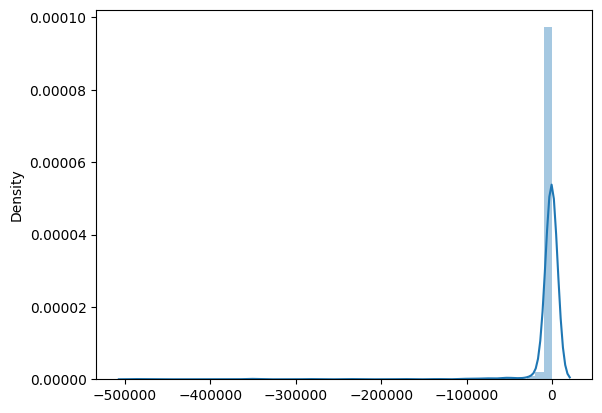

(2,)
[6.2779231e-06 6.2887175e-06 6.3016828e-06 ... 8.5426712e-01 1.5363243e+00
 7.1452055e+00]
(150, 150)


Text(0.5, 1.0, 'montecarlo likelihood and observations')

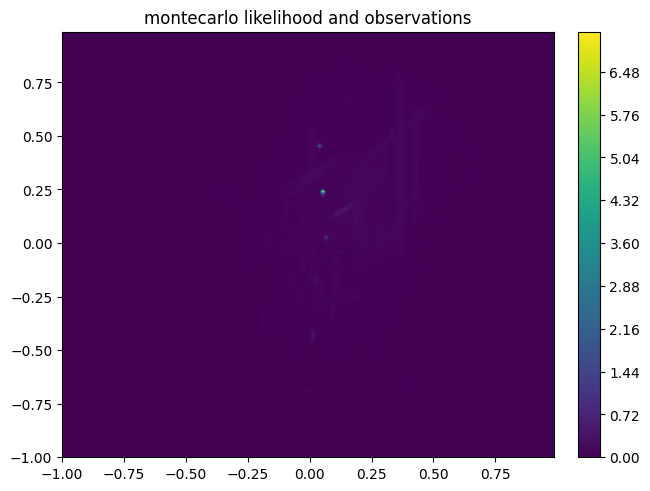

In [11]:
idx = 0
num_mix_hat_2, means_hat_2, cov_terms_2 = vmap(m.rsample, in_axes=(None,0))(obs[idx],split(PRNGKey(5),1000))
my_log_prob = lambda x: jnp.exp(vmap(gaussian_mixture_log_p_single_obs, in_axes=(None,0,0,0))(x,
                                                                                      means_hat_2,
                                                                                      cov_terms_2,
                                                                                      num_mix_hat_2)).mean()
draw_bivariate_dist(my_log_prob,[-1,-1],[1,1],150)
# log_prob(jnp.stack([.0,.1]))
# vmap(vmap(make_grid, in_axes=(None,0)),in_axes=(0,None))(x,x).reshape(-1,2)
# plt.scatter(obs[idx,:,0],obs[idx,:,1], color="red", alpha=0.4, s=4)
# plt.xlim(-1.2,1.2)
# plt.ylim(-1.2,1.2)
plt.title("montecarlo likelihood and observations")
# means_hat[5][:num_mix_hat[5]+1]

In [16]:
gaussian_mixture_log_p(obs, means=means, cov_terms=jnp.stack([jnp.array([1.0,0.0,1.0])]*6)/(50**0.5), num_mixtures=4, max_num_mixtures=6)

Array(234.17653, dtype=float32)

In [4]:
num_mixtures, means, cov_terms, class_labels, obs = vmap(gaussian_mixture)(
        split(PRNGKey(0),200))

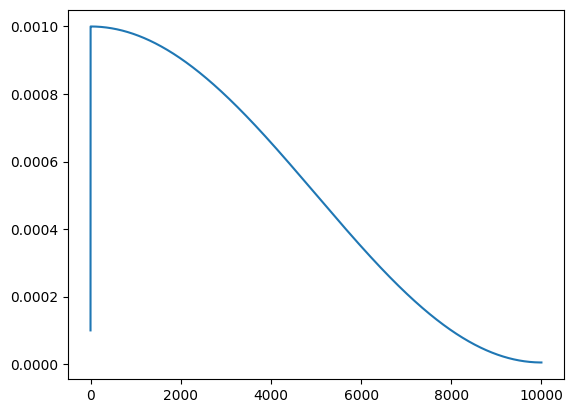

In [18]:
import optax
from matplotlib import pyplot as plt
o = optax.cosine_onecycle_schedule(
                10000,
                0.001,
                0.0001,
                1e1,
                2e1,
            )
plt.plot([o(s) for s in range(10000)])

In [ ]:
jnp.log

In [25]:
0.7/0.6

1.1666666666666667

(Array(0.00065633, dtype=float32, weak_type=True),
 Array(0.00053382, dtype=float32, weak_type=True))

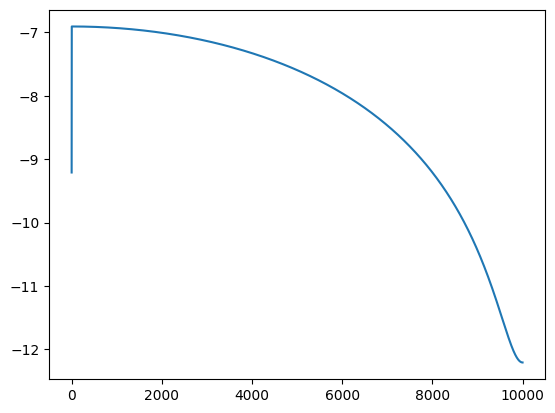

In [24]:
plt.plot(jnp.log(vmap(o)(jnp.arange(10000))))
o(4000), o(4800)

In [14]:
vmap(gaussian_mixture_log_p)(obs, means=means+0.5, cov_terms=jnp.stack([jnp.stack([jnp.array([1.0,0.0,1.0])]*6)/(50)]*obs.shape[0]), 
                                             num_mixtures=num_mixtures).mean()

Array(-578.86743, dtype=float32)

In [ ]:
obs_log_p = vmap(gaussian_mixture_log_p)(obs, means=means+0.5, cov_terms=jnp.stack([jnp.array([1.0,0.0,1.0])]*6)/(50), num_mixtures=num_mixtures, max_num_mixtures=6)

In [9]:
gaussian_mixture_log_p(obs, means=means, cov_terms=jnp.stack([jnp.array([1.0,0.0,1.0])]*6)/(50*10), num_mixtures=4, max_num_mixtures=6)

AssertionError: 